In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

from gensim.models import KeyedVectors
from gensim.downloader import load

glove_model = load('glove-wiki-gigaword-50')
#fast_text_model = KeyedVectors.load_word2vec_format("data/wiki-news-300d-1M.vec", binary=False)

from sentence_transformers import SentenceTransformer, util

# Load model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('data/wiki_movie_plots_deduped.csv')
df = df.drop(columns=['Director', 'Cast', 'Wiki Page'])
df.head(3)

,Release Year,Title,Origin/Ethnicity,Genre,Plot
0,1901,Kansas Saloon Smashers,American,unknown,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,unknown,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,unknown,"The film, just over a minute long, is composed..."


In [3]:
df_known = pd.read_excel('data/Known_Plots.xlsx')
df_known.head(3)

,Drama,Romance,Comedy
0,"In 1947, Portland, Maine, banker Andy Dufresne...",In 1981 a feather lands at a bus stop in Savan...,"A group of lazy, ignorant highschool students,..."
1,"In 1945, the don of New York City's Corleone f...","Part I In 1939, in Fascist Italy, young Italia...","At night in Paris, Driss is driving Philippe's..."
2,A gang of masked criminals rob a mafia-owned b...,"On Christmas Eve 1945, in Bedford Falls, New Y...",A Labrador puppy escapes from the house of a b...


In [4]:
import yake
number_of_important_words = 50
stop_words = set(stopwords.words('english'))

def get_important_words(plot, n):
    print(plot)
    # Simple usage with default parameters
    kw_extractor = yake.KeywordExtractor()
    keywords = kw_extractor.extract_keywords(plot)

    keywords_sorted = sorted(keywords, key=lambda x: x[1], reverse=True)

    important_words = []

    for kw, score in keywords_sorted:
        split_list = kw.split(' ')
        for word in split_list:
            if word not in stop_words:
                important_words.append(word)
                if len(important_words) == n:
                    break

    return important_words

In [5]:
comedic_plots = df_known['Comedy'].tolist()
known_important_words_comedy = []

for plot in comedic_plots:
    known_important_words_comedy.extend(get_important_words(plot, number_of_important_words/5))


dramatic_plots = df_known['Drama'].tolist()
known_important_words_drama = []

for plot in dramatic_plots:
    known_important_words_drama.extend(get_important_words(plot, number_of_important_words/5))


romantic_plots = df_known['Romance'].tolist()
known_important_words_romance = []

for plot in comedic_plots:
    known_important_words_romance.extend(get_important_words(plot, number_of_important_words/5))



print(known_important_words_comedy)
print(known_important_words_drama)
print(known_important_words_romance)

A group of lazy, ignorant highschool students, in no rush to graduate, have settled into life at their private school, paid by aloof parents, where they have bonded as a family and are cared for by school attendant Mother Hafize who has accepted them as her real sons. Their kingdom over the school is challenged by a new vice principal who, despite his warm hearted nature, takes on the role of tough disciplinarian and becomes the butt of their tricks and jokes as he prepares them for life.
At night in Paris, Driss is driving Philippe's Maserati Quattroporte at high speed. Chased through the streets by the police, they are eventually cornered. Driss claims the quadriplegic Philippe must get to a hospital urgently; Philippe pretends to have a seizure and the fooled police officers escort them. After arriving at the hospital, Driss drives away. The story of friendship between the two men is then told as a flashback: Philippe, a wealthy quadriplegic owner of a luxurious hôtel particulier, a

In [6]:
import math
beta = 0.01
threshold = 0.3

failcount = 0


'''sim = glove_model.similarity(word, word_checked.lower())                
                if score > 0.3:
                    score *= math.exp(beta * sim)'''


def similarity_lists(unknown, genre_known):
    global failcount
    
    score = 1

    for word in unknown:
        try:
            emb1 = bert_model.encode(word, convert_to_tensor=True)
        except:
            failcount += 1
            continue

        for word_checked in genre_known:
            
            try:
                emb2 = bert_model.encode(word_checked, convert_to_tensor=True)
            except:
                failcount += 1
                continue

            score += float(util.cos_sim(emb1, emb2))
        #print(failcount)
    return score

In [7]:
def similarity_to_genres(plot):
    big_list = []
    this_important_words = get_important_words(plot, number_of_important_words)
    similarity_list = []

    similarity = similarity_lists(this_important_words, known_important_words_drama)
    similarity_list.append(similarity)

    big_list.append(float(similarity_list[0]))

    similarity_list = []

    similarity = similarity_lists(this_important_words, known_important_words_romance)
    similarity_list.append(similarity)

    big_list.append(float(similarity_list[0]))

    return big_list


for i in range(1000, 1005):
    print(similarity_to_genres(df.iloc[i]['Plot']),  df.iloc[i]['Genre'])

Loretta Young plays the part of an orphan who has been raised by two thieves (Raymond Hatton and George Barraud) and does not know that she has a twin sister who is now a wealthy socialite (Loretta Young as Margaret Waring). One day, while she is dining at a Chinese restaurant with her two guardians, they notice the wealthy socialite and are taken aback at how closely she resembles Young. Hatton and Barraud convince Young that she should impersonate the socialite so that they can enter her house and steal the contents of her safe. Young enters the house and meet Jack Mulhall who senses something different about Waring and immediately falls in love with Young. When night falls, Young lets Hatton and Barraud into the house and they attempt to open the safe. Waring happens to enter the house and is shocked to find a woman that looks like her. She is wounded by Barraud and Young tricks the police into thinking that Waring is an imposter and thief. Even though Mulhall knows the truth, he ke

In [8]:
n = 1000 
df_sample = df.head(n)

labels = df_sample['Genre'].values

In [ ]:
X = np.zeros((n, 2))


for i, plot in enumerate(df_sample['Plot']):
    X[i] = similarity_to_genres(plot)

#print(X)

A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]
The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better.


C:\Users\Christian\AppData\Local\Temp\ipykernel_38732\1967159267.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], c=mapped_colors, cmap='viridis')


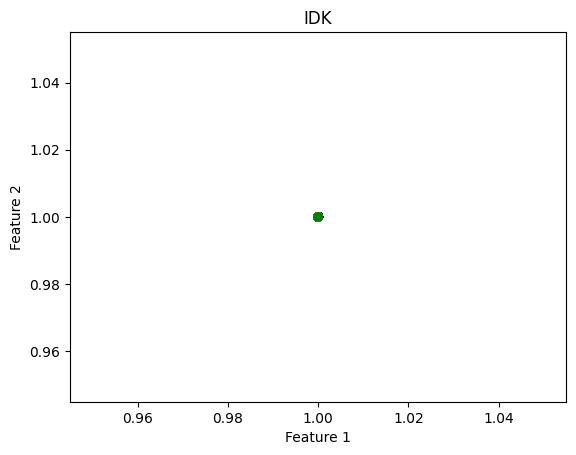

{'romance': 'red', 'comedy': 'blue', 'drama': 'green'}


In [ ]:
import matplotlib.colors as mcolors

color_map = {
    'romance': 'red',
    'comedy': 'blue',
    'drama': 'green'
}

default_color = 'gray'

mapped_colors = [mcolors.to_hex(color_map.get(g, default_color)) for g in labels]

plt.scatter(X[:, 0], X[:, 1], c=mapped_colors, cmap='viridis')
plt.title("IDK")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

#plt.axis([0, 10, -10, 10])
plt.show()

print(color_map)

In [ ]:
print(X)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]


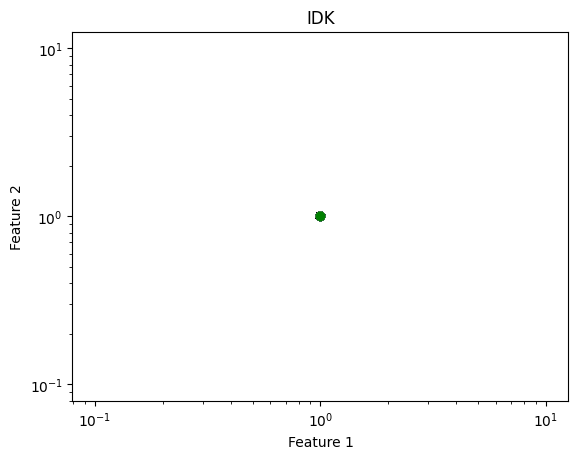

{'romance': 'red', 'comedy': 'blue', 'drama': 'green'}


In [ ]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

color_map = {
    'romance': 'red',
    'comedy': 'blue',
    'drama': 'green'
}

default_color = 'gray'

mapped_colors = [mcolors.to_hex(color_map.get(g, default_color)) for g in labels]

plt.scatter(X[:, 0], X[:, 1], c=mapped_colors)
plt.title("IDK")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Make axes logarithmic
plt.xscale("log")
plt.yscale("log")

plt.show()

print(color_map)
